# Set Env

In [1]:
import os
import platform
import copy
import random
import pandas as pd
import numpy as np
# import seaborn as sns
# import pmdarima as pm
import matplotlib.pylab as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime, date
from typing import Dict, Iterable, Tuple, List
# from statsmodels.tsa.x13 import x13_arima_analysis
from sklearn.ensemble import RandomForestRegressor as RFR
from  xgboost import XGBRegressor as XGBR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore

In [4]:
seed_everything(0)

# Load Data

In [5]:
data = pd.read_excel(f'data(SA){20240429}.xlsx', index_col=0)
data.index = pd.PeriodIndex(data.index, freq='M')

In [6]:
metaData = pd.read_excel('meta20230525.xlsx', index_col='Variable')

In [7]:
len(metaData)

145

# Util Func

In [8]:
def preprocess(dat: pd.DataFrame) -> pd.DataFrame:
    #dat = x13SA(dat)
    dat = log(dat)
    dat = convertToQuarterlyMean(dat)
    dat = diff(dat)
    dat = dropStartingNa(dat)
    return dat

## Log

In [9]:
def log(dat: pd.DataFrame) -> pd.DataFrame:
  dat = copy.deepcopy(dat)
  for col in filter(lambda col: '금리' not in col and '수지' not in col and '률' not in col, dat.columns):
    dat[col] = np.log(dat[col]) * 100
  return dat

## Quarterly mean

In [10]:
def convertToQuarterlyMean(dat: pd.DataFrame) -> pd.DataFrame:
    return dat.groupby(dat.index.asfreq('Q')).mean()

## Diff

In [11]:
def diff(dat: pd.DataFrame) -> pd.DataFrame:
    return dat.diff().iloc[1:]

## Drop starting na

In [12]:
def dropStartingNa(dat: pd.DataFrame) -> pd.DataFrame:
  if 'GDP(SA)' in dat.columns:
    tempData = dat.drop(columns=['GDP(SA)'])
  else:
    tempData = dat

  dropIndex = []
  i = 0
  while i < len(dat) and any(tempData.iloc[i].isna()):
      dropIndex.append(dat.index[i])
      i += 1
  return dat.drop(index=dropIndex)

## Set criteria

In [13]:
def rmse(y_pred,y_true, digits=3):
    return np.round(np.sqrt(np.mean((y_pred-y_true)**2)), digits)
def rmseStd(y_pred,y_true, digits=3):
    return np.round(np.std((y_pred-y_true)**2), digits)

def mae(y_pred,y_true, digits=3):
    return np.round(np.mean(np.abs(y_pred-y_true)), digits)
def maeStd(y_pred,y_true, digits=3):
    return np.round(np.std(np.abs(y_pred-y_true)), digits)

def maxe(y_pred,y_true, digits=3):
    return np.round(np.max(np.abs(y_pred-y_true)), digits)
def maxeStd(y_pred,y_true, digits=3):
    return np.round(np.std(np.abs(y_pred-y_true)), digits)



# Ragged-edge Extrapolation

## Pad na

In [14]:
def padNa(dat: pd.DataFrame) -> pd.DataFrame:
  return dat.fillna(0.0)

## Shift Non Target Varialbes

In [15]:
def shiftNonTargetVariables(dat: pd.DataFrame, target: str='GDP(SA)') -> pd.DataFrame:
  dat = copy.deepcopy(dat)
  for col in dat.columns:
    if col == target:
      continue
    while np.isnan(dat.iloc[-1][col]):
      dat[col] = dat[col].shift()
  return dat

## ARIMA

In [16]:
def countNasTrailing(series: pd.Series) -> int:
  is_na_reversed = series[::-1].isna()

  # Create a reversed series where each True is replaced with 1
  # and each False (after the first) with 0.
  na_count_reversed = is_na_reversed.cumprod()

  # Count the number of trailing NaNs by summing the reversed count
  na_trailing_count = int(na_count_reversed.sum())
  return na_trailing_count

In [17]:
def ArimaExrapolationForMonthlySeries_old(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  naTrailingCount = countNasTrailing(series)
  if naTrailingCount == 0:
    return series

  naDroppedSeries = series.dropna()
  autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=False, m=0)
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=True, m=12) # Too slow
  # print(autoArimaModel.summary)
  predicted = autoArimaModel.predict(naTrailingCount)
  # res = ARIMA(naDroppedSeries, order=(1,1,1)).fit()
  # predicted = res.forecast(naTrailingCount)
  return series.fillna(predicted)

In [18]:
def ArimaExrapolationForMonthlySeries(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  naTrailingCount = countNasTrailing(series)
  if naTrailingCount == 0:
    return series

  naDroppedSeries = series.dropna()
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=False, m=0)
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=True, m=12) # Too slow
  # print(autoArimaModel.summary)
  # predicted = autoArimaModel.predict(naTrailingCount)
  # res = ARIMA(naDroppedSeries, order=(1,1,1)).fit()
  res = ARIMA(naDroppedSeries, order=(3,0,0), enforce_stationarity=False, enforce_invertibility=False).fit()
  predicted = res.forecast(naTrailingCount)
  return series.fillna(predicted)

In [19]:
def ArimaExrapolationForQuarterlySeries_old(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  seriesAsQuarterly = convertToQuarterlyMean(series)
  naTrailingCount = countNasTrailing(seriesAsQuarterly)
  if naTrailingCount == 0:
    return series

  naDroppedSeries = seriesAsQuarterly.dropna()
  autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=False, m=0)
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=True, m=4) # Too slow
  # print(autoArimaModel.summary)
  predicted = autoArimaModel.predict(naTrailingCount)
  # res = ARIMA(naDroppedSeries, order=(1,1,1)).fit()
  # predicted = res.forecast(naTrailingCount)
  return series.fillna(predicted.asfreq('M'))

In [20]:
def ArimaExrapolationForQuarterlySeries(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  seriesAsQuarterly = convertToQuarterlyMean(series)
  naTrailingCount = countNasTrailing(seriesAsQuarterly)
  if naTrailingCount == 0:
    return series

  naDroppedSeries = seriesAsQuarterly.dropna()
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=False, m=0)
  # autoArimaModel = pm.auto_arima(naDroppedSeries, seasonal=True, m=4) # Too slow
  # print(autoArimaModel.summary)
  # predicted = autoArimaModel.predict(naTrailingCount)
  # res = ARIMA(naDroppedSeries, order=(1,1,1)).fit()
  res = ARIMA(naDroppedSeries, order=(1,1,1)).fit()
  predicted = res.forecast(naTrailingCount)
  return series.fillna(predicted.asfreq('M'))

In [21]:
def ArimaExrapolation(dat: pd.DataFrame, target: str='GDP(SA)') -> pd.DataFrame:
  dat = copy.deepcopy(dat)
  for col in dat.columns:
    if col == target:
      continue
    elif 'GDP' in col:
      dat[col] = ArimaExrapolationForQuarterlySeries(dat[col])
    else:
      dat[col] = ArimaExrapolationForMonthlySeries(dat[col])
  return dat

## K-Nearest Neighbor

In [22]:
def knnExtraplation(dat: pd.DataFrame, target: str='GDP(SA)') -> pd.DataFrame:
  dat = copy.deepcopy(dat)

  # Training
  regressorDict = dict()
  parameters = {
      'kneighborsregressor__n_neighbors': [2], #range(2,10),
      # 'kneighborsregressor__n_neighbors': [5], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }

  # Monthly
  monthlyVariables = list(filter(lambda col: 'GDP' not in col, dat.columns))
  tempDataMonthly = copy.deepcopy(dat).drop(columns=target)[monthlyVariables]
  tempDataMonthly = tempDataMonthly/tempDataMonthly.shift(1) - 1
  tempDataMonthlyNonNa = tempDataMonthly.dropna()
  for col in monthlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        # ).fit(tempDataMonthlyNonNa.values[:-2], tempDataMonthlyNonNa[col].values[2:])
        # ).fit(np.concatenate([tempDataMonthlyNonNa.values[:-2], tempDataMonthlyNonNa.values[1:-1]], axis=1), tempDataMonthlyNonNa[col].values[2:])
        ).fit(tempDataMonthlyNonNa.values[:-1], tempDataMonthlyNonNa[col].values[1:])

  parameters = {
      'kneighborsregressor__n_neighbors': [3], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }
  # Quarterly
  quarterlyVariables = list(filter(lambda col: 'GDP' in col, dat.columns))
  quarterlyVariables.remove(target)
  tempDataQuarterly = copy.deepcopy(dat).drop(columns=target)
  tempDataQuarterly = convertToQuarterlyMean(tempDataQuarterly)
  tempDataQuarterly = tempDataQuarterly/tempDataQuarterly.shift(1) - 1
  tempDataQuarterlyNonNa = tempDataQuarterly.dropna()
  for col in quarterlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        ).fit(tempDataQuarterlyNonNa.values[:-1], tempDataQuarterlyNonNa[col].values[1:])

  # Predict

  # Monthly
  tempDataMonthly = dropStartingNa(tempDataMonthly)
  assert len(tempDataMonthly) > 1
  for date, val in zip(tempDataMonthly.index, tempDataMonthly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in monthlyVariables:
      if np.isnan(tempDataMonthly[col].loc[date]):
        # tempDataMonthly[col].loc[date] = regressorDict[col].predict(tempDataMonthly.loc[:date].values[-2].reshape(1, -1))
        tempDataMonthly.loc[date, col] = regressorDict[col].predict(tempDataMonthly.loc[:date].values[-2].reshape(1, -1))
        # tempDataMonthly.loc[date, col] = regressorDict[col].predict(np.concatenate([tempDataMonthly.loc[:date].values[-3], tempDataMonthly.loc[:date].values[-2]]).reshape(1, -1))
        # dat[col].loc[date] = dat[col].loc[date -1] * (1 + tempDataMonthly[col].loc[date])
        dat.loc[date, col] = dat[col].loc[date -1] * (1 + tempDataMonthly[col].loc[date])

  # Quarterly
  tempDataQuarterly = dropStartingNa(convertToQuarterlyMean(copy.deepcopy(dat).drop(columns=target)))
  assert len(tempDataQuarterly) > 1
  for date, val in zip(tempDataQuarterly.index, tempDataQuarterly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in quarterlyVariables:
      if np.isnan(tempDataQuarterly[col].loc[date]):
        tempDataQuarterly.loc[date, col] = regressorDict[col].predict(tempDataQuarterly.loc[:date].values[-2].reshape(1, -1))
        # dat[col].loc[date.asfreq('M')] = dat[col].loc[(date - 1).asfreq('M')] * (1 + tempDataQuarterly[col].loc[date])
        dat.loc[date.asfreq('M'), col] = dat[col].loc[(date - 1).asfreq('M')] * (1 + tempDataQuarterly[col].loc[date])

  return dat

In [23]:
def knnExtraplation_old2(dat: pd.DataFrame, target: str='GDP(SA)') -> pd.DataFrame:
  dat = copy.deepcopy(dat)

  # Training
  regressorDict = dict()
  parameters = {
      'kneighborsregressor__n_neighbors': [5], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }

  # Monthly
  monthlyVariables = list(filter(lambda col: 'GDP' not in col, dat.columns))
  tempDataMonthly = copy.deepcopy(dat).drop(columns=target)[monthlyVariables]
  tempDataMonthly = tempDataMonthly/tempDataMonthly.shift(1)
  tempDataMonthlyNonNa = tempDataMonthly.dropna()
  for col in monthlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        ).fit(tempDataMonthlyNonNa.values[:-1], tempDataMonthlyNonNa[col].values[1:])

  parameters = {
      'kneighborsregressor__n_neighbors': [3], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }
  # Quarterly
  quarterlyVariables = list(filter(lambda col: 'GDP' in col, dat.columns))
  quarterlyVariables.remove(target)
  tempDataQuarterly = copy.deepcopy(dat).drop(columns=target)
  tempDataQuarterly = convertToQuarterlyMean(tempDataQuarterly)
  tempDataQuarterly = tempDataQuarterly/tempDataQuarterly.shift(1)
  tempDataQuarterlyNonNa = tempDataQuarterly.dropna()
  for col in quarterlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        ).fit(tempDataQuarterlyNonNa.values[:-1], tempDataQuarterlyNonNa[col].values[1:])

  # Predict

  # Monthly
  tempDataMonthly = dropStartingNa(tempDataMonthly)
  assert len(tempDataMonthly) > 0
  for date, val in zip(tempDataMonthly.index, tempDataMonthly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in monthlyVariables:
      if np.isnan(tempDataMonthly[col].loc[date]):
        tempDataMonthly[col].loc[date] = regressorDict[col].predict(tempDataMonthly.loc[:date].values[-2].reshape(1, -1))
        dat[col].loc[date] = dat[col].loc[date -1] * tempDataMonthly[col].loc[date]

  # Quarterly
  tempDataQuarterly = dropStartingNa(convertToQuarterlyMean(copy.deepcopy(dat).drop(columns=target)))
  assert len(tempDataQuarterly) > 0
  for date, val in zip(tempDataQuarterly.index, tempDataQuarterly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in quarterlyVariables:
      if np.isnan(tempDataQuarterly[col].loc[date]):
        tempDataQuarterly[col].loc[date] = regressorDict[col].predict(tempDataQuarterly.loc[:date].values[-2].reshape(1, -1))
        dat[col].loc[date.asfreq('M')] = dat[col].loc[(date - 1).asfreq('M')] * tempDataQuarterly[col].loc[date]

  return dat

In [24]:
def knnExtraplation_old(dat: pd.DataFrame, target: str='GDP(SA)') -> pd.DataFrame:
  dat = copy.deepcopy(dat)

  # Training
  regressorDict = dict()
  parameters = {
      'kneighborsregressor__n_neighbors': [5], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }

  # Monthly
  monthlyVariables = list(filter(lambda col: 'GDP' not in col, dat.columns))
  tempDataMonthly = copy.deepcopy(dat).drop(columns=target)[monthlyVariables]
  tempDataMonthlyNonNa = tempDataMonthly.dropna()
  for col in monthlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        ).fit(tempDataMonthlyNonNa.values[:-1], tempDataMonthlyNonNa[col].values[1:])

  parameters = {
      'kneighborsregressor__n_neighbors': [3], #range(2,10),
      'kneighborsregressor__weights':['distance']
      }
  # Quarterly
  quarterlyVariables = list(filter(lambda col: 'GDP' in col, dat.columns))
  quarterlyVariables.remove(target)
  tempDataQuarterly = copy.deepcopy(dat).drop(columns=target)
  tempDataQuarterly = convertToQuarterlyMean(tempDataQuarterly)
  tempDataQuarterlyNonNa = tempDataQuarterly.dropna()
  for col in quarterlyVariables:
    regressorDict[col] = GridSearchCV(
        make_pipeline(StandardScaler(), KNeighborsRegressor()),
        parameters
        ).fit(tempDataQuarterlyNonNa.values[:-1], tempDataQuarterlyNonNa[col].values[1:])

  # Predict

  # Monthly
  tempDataMonthly = dropStartingNa(tempDataMonthly)
  assert len(tempDataMonthly) > 0
  for date, val in zip(tempDataMonthly.index, tempDataMonthly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in monthlyVariables:
      if np.isnan(tempDataMonthly[col].loc[date]):
        tempDataMonthly[col].loc[date] = regressorDict[col].predict(tempDataMonthly.loc[:date].values[-2].reshape(1, -1))
        dat[col].loc[date] = tempDataMonthly[col].loc[date]

  # Quarterly
  tempDataQuarterly = dropStartingNa(convertToQuarterlyMean(copy.deepcopy(dat).drop(columns=target)))
  assert len(tempDataQuarterly) > 0
  for date, val in zip(tempDataQuarterly.index, tempDataQuarterly.isna().apply(sum, axis=1)):
    if val == 0:
      continue
    for col in quarterlyVariables:
      if np.isnan(tempDataQuarterly[col].loc[date]):
        tempDataQuarterly[col].loc[date] = regressorDict[col].predict(tempDataQuarterly.loc[:date].values[-2].reshape(1, -1))
        dat[col].loc[date.asfreq('M')] = tempDataQuarterly[col].loc[date]

  return dat

# Select Variables

In [25]:
def selectVarialbes(dat: pd.DataFrame, metaData: pd.DataFrame, target: str='GDP(SA)') -> List[str]:
  variables = [target]
  for category in metaData.Category.unique():
    if category == 'target':
      continue
    tempData = dat[[target]].join([dat[metaData[metaData.Category == category].index]])
    try:
      variables.append(tempData.corr()[target].drop(target).idxmax())
    except:
      continue
  return variables

## Pre-selected

### Sentiment Variables

In [26]:
sentimentBasedVarialbes = ['GDP(SA)', '전산업매출실적BSI', '전산업업황실적BSI', '전산업채산성실적BSI', '전산업자금사정실적BSI',
       '전산업인력사정실적BSI', '제조업업황실적BSI(SA)', '비제조업업황실적BSI(SA)', '제조업업황전망BSI(SA)',
       '비제조업업황전망BSI(SA)', 'NSI', '경제심리지수(순환변동치)',]

### Core Variables

In [27]:
coreVarialbes = ['GDP(SA)', 'KOSPI(평균)', '수출액', '원달러환율(평균)', '설비투자지수(SA)', '전산업생산지수(SA)', '소매판매액지수(SA)', '선행지수순환변동치', '실업률(SA)', 'WTI유가현물']

# Split TrainX, TrainY, TestX

In [28]:
def splitAndRollingData(dat: pd.DataFrame, seqLength: int, target: str='GDP(SA)') -> Tuple[np.ndarray]:
  # Use all observed gdp

  dat = copy.deepcopy(dat)
  # with target lag term
  # trainY = dat[target].iloc[seqLength - 1 + 1 + 0:-1].values

  # without target lag term
  #trainY = dat[target].iloc[seqLength - 1 + 0:-1 - ahead].values
  trainY = dat[target].dropna().iloc[seqLength - 1 + 0:].values

  # with target lag term
  # dat[target] = dat[target].shift(1)
  # dat = dat.dropna()

  # without target lag term
  dat = dat.drop(columns=target)

  trainX = []
  #for start in range(len(dat) - seqLength - 0 - ahead):
  for start in range(len(trainY)):
    end = start + seqLength
    tempData = copy.deepcopy(dat.iloc[start:end])
    trainX.append(tempData.values)

  testX = np.expand_dims(copy.deepcopy(dat.iloc[-seqLength:]).values, axis=0)
  return (np.array(trainX), trainY, testX)


# Models

## LQR

In [29]:
q=0.5
vcov='robust'
kernel = 'epa'
bandwidth = 'hsheather'
p_tol = 1e-01 # Impact!!
def LQRPredict(trainX, trainY, testX):
    return QuantReg(trainY,trainX.reshape(len(trainX), -1)).fit(q=0.5, vcov=vcov, kernel=kernel, bandwidth=bandwidth, p_tol=p_tol).predict(testX.reshape(len(testX), -1))

## OptimARIMA

In [30]:
def optimize_mARIMA(parameters_list, endg, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q) tuples
        d - integration order
        exog - the exogenous variable
    """

    results = []
    for param in parameters_list:
        model = ARIMA(endg, exog, order=(param[0], param[1], param[2])).fit()

        aic = model.aic
        results.append([param, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
#     print(result_df)
    return result_df

p = range(0, 4, 1)
d = range(0, 2, 1)
q = range(0, 2, 1)
parameters = product(p, d, q)
parameters_list = list(parameters)

import warnings
warnings.filterwarnings("ignore")

def OAMPredict(trainX, trainY, testX):
    trainX = trainX.reshape(len(trainX), -1)
    testX = testX.reshape(len(testX), -1)
    result_df = optimize_mARIMA(parameters_list, trainY, trainX)
    # print(result_df)
    print(result_df['(p,q)'][0])
    # print(result_df.iloc[0][0])
    # return ARIMA(trainY, exog=trainX, order=result_df.iloc[0][0]).fit().forecast(1,exog=testX)
    return ARIMA(trainY, exog=trainX, order=result_df['(p,q)'][0]).fit().forecast(1,exog=testX)

## SVM

In [31]:
def SVRPredict(trainX, trainY, testX):
  return SVR(kernel='rbf', gamma=1e-8, C=4e5, epsilon=1e-12, tol=1e-4).fit(trainX.reshape(len(trainX), -1), trainY).predict(testX.reshape(len(testX), -1))

## Random Forest

In [32]:
def randomForestPredict(trainX, trainY, testX):
  return RFR(n_estimators=100, random_state=0).fit(trainX.reshape(len(trainX), -1), trainY).predict(testX.reshape(len(testX), -1))

## XGBoost

In [41]:
# subsample = 0.5
subsample = 0.75
reg_alpha = 1.5
reg_lambda = 1.0
gamma = 2.0
learning_rate = 0.3
def XGBoostPredict(trainX, trainY, testX):
  return XGBR(n_estimators=50,learning_rate=learning_rate,max_depth=3,subsample=subsample,randome_state=0,reg_alpha=reg_alpha, reg_lambda=reg_lambda, gamma=gamma).fit(trainX.reshape(len(trainX), -1), trainY).predict(testX.reshape(len(testX), -1))

# Back Test

In [34]:
results = pd.DataFrame(
    index=pd.period_range(start='2007Q1', end='2016Q1', freq='Q'),
    columns=[
        'lqr_nowcasting', 'oam_nowcasting', 'svr_nowcasting', 'rf_nowcasting', 'xgb_nowcasting',
        'lqr_nowcasting_1Q_ahead', 'oam_nowcasting_1Q_ahead', 'svr_nowcasting_1Q_ahead', 'rf_nowcasting_1Q_ahead', 'xgb_nowcasting_1Q_ahead'
        ]
    )

In [35]:
# for period in results.index:
#     print(period)

#     period_str = str(period)
#     tempData = data.loc[:period_str].copy()
#     for col in tempData:
#         lag = metaData.loc[col, 'Lag']
#         if lag == 0:
#             continue
#         # tempData[col].iloc[-lag:] = pd.NA
#         tempCol = tempData[col]
#         tempCol.iloc[-lag:] = pd.NA
#         tempData[col] = tempCol
#     realtimeData = tempData.copy()

#     # lqr, oam
#     tempData = preprocess(ArimaExrapolation(realtimeData[coreVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = LQRPredict(trainX, trainY, testX)
#     results.loc[period_str, 'lqr_nowcasting'] = test_y[0]
#     test_y = OAMPredict(trainX, trainY, testX)
#     results.loc[period_str, 'oam_nowcasting'] = test_y[0]

#     # svr
#     tempData = preprocess(knnExtraplation(realtimeData[coreVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = SVRPredict(trainX, trainY, testX)
#     results.loc[period_str, 'svr_nowcasting'] = test_y[0]

#     # rf
#     selectedVariables = list(filter(lambda x: pd.notna(x), selectVarialbes(realtimeData, metaData)))
#     selectedVariables = list(filter(lambda x: len(realtimeData[x].dropna()) > 24, selectedVariables))
#     tempData = preprocess(knnExtraplation(realtimeData[selectedVariables]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = randomForestPredict(trainX, trainY, testX)
#     results.loc[period_str, 'rf_nowcasting'] = test_y[0]

#     # xgb
#     tempData = preprocess(ArimaExrapolation(realtimeData[sentimentBasedVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = XGBoostPredict(trainX, trainY, testX)
#     results.loc[period_str, 'xgb_nowcasting'] = test_y[0]

In [36]:
# for period in results.index:
#     print(period)

#     period_str = str(period)
#     tempData = data.loc[:period_str].copy()
#     for col in tempData:
#         lag = metaData.loc[col, 'Lag']
#         # tempData[col].iloc[-3-lag:] = pd.NA
#         tempCol = tempData[col]
#         tempCol.iloc[-3-lag:] = pd.NA
#         tempData[col] = tempCol
#     realtimeData = tempData.copy()

#     # lqr, oam
#     tempData = preprocess(ArimaExrapolation(realtimeData[coreVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = LQRPredict(trainX, trainY, testX)
#     results.loc[period_str, 'lqr_nowcasting_1Q_ahead'] = test_y[0]
#     test_y = OAMPredict(trainX, trainY, testX)
#     results.loc[period_str, 'oam_nowcasting_1Q_ahead'] = test_y[0]

#     # svr
#     tempData = preprocess(knnExtraplation(realtimeData[coreVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = SVRPredict(trainX, trainY, testX)
#     results.loc[period_str, 'svr_nowcasting_1Q_ahead'] = test_y[0]

#     # rf
#     selectedVariables = list(filter(lambda x: pd.notna(x), selectVarialbes(realtimeData, metaData)))
#     selectedVariables = list(filter(lambda x: len(realtimeData[x].dropna()) > 24, selectedVariables))
#     tempData = preprocess(knnExtraplation(realtimeData[selectedVariables]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = randomForestPredict(trainX, trainY, testX)
#     results.loc[period_str, 'rf_nowcasting_1Q_ahead'] = test_y[0]

#     # xgb
#     tempData = preprocess(ArimaExrapolation(realtimeData[sentimentBasedVarialbes]))
#     trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
#     test_y = XGBoostPredict(trainX, trainY, testX)
#     results.loc[period_str, 'xgb_nowcasting_1Q_ahead'] = test_y[0]

In [37]:
for period in results.index:
    print(period)

    period_str = str(period)
    tempData = data.loc[:period_str].copy()
    for col in tempData:
        lag = metaData.loc[col, 'Lag']
        # tempData[col].iloc[-3-lag:] = pd.NA
        tempCol = tempData[col]
        tempCol.iloc[-3-lag:] = pd.NA
        tempData[col] = tempCol
    realtimeData = tempData.copy()

    # lqr, oam
    # tempData = preprocess(ArimaExrapolation(realtimeData[coreVarialbes]))
    # trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
    # test_y = LQRPredict(trainX, trainY, testX)
    # results.loc[period_str, 'lqr_nowcasting_1Q_ahead'] = test_y[0]
    # test_y = OAMPredict(trainX, trainY, testX)
    # results.loc[period_str, 'oam_nowcasting_1Q_ahead'] = test_y[0]

    # svr
    tempData = preprocess(knnExtraplation(realtimeData[coreVarialbes]))
    trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
    test_y = SVRPredict(trainX, trainY, testX)
    results.loc[period_str, 'svr_nowcasting_1Q_ahead'] = test_y[0]

    # rf
    # selectedVariables = list(filter(lambda x: pd.notna(x), selectVarialbes(realtimeData, metaData)))
    # selectedVariables = list(filter(lambda x: len(realtimeData[x].dropna()) > 24, selectedVariables))
    # tempData = preprocess(knnExtraplation(realtimeData[selectedVariables]))
    # trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
    # test_y = randomForestPredict(trainX, trainY, testX)
    # results.loc[period_str, 'rf_nowcasting_1Q_ahead'] = test_y[0]

    # xgb
    tempData = preprocess(ArimaExrapolation(realtimeData[sentimentBasedVarialbes]))
    trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
    test_y = XGBoostPredict(trainX, trainY, testX)
    results.loc[period_str, 'xgb_nowcasting_1Q_ahead'] = test_y[0]

2007Q1
2007Q2
2007Q3
2007Q4
2008Q1
2008Q2
2008Q3
2008Q4
2009Q1
2009Q2
2009Q3
2009Q4
2010Q1
2010Q2
2010Q3
2010Q4
2011Q1
2011Q2
2011Q3
2011Q4
2012Q1
2012Q2
2012Q3
2012Q4
2013Q1
2013Q2
2013Q3
2013Q4
2014Q1
2014Q2
2014Q3
2014Q4
2015Q1
2015Q2
2015Q3
2015Q4
2016Q1


In [38]:
results

,lqr_nowcasting,oam_nowcasting,svr_nowcasting,rf_nowcasting,xgb_nowcasting,lqr_nowcasting_1Q_ahead,oam_nowcasting_1Q_ahead,svr_nowcasting_1Q_ahead,rf_nowcasting_1Q_ahead,xgb_nowcasting_1Q_ahead
2007Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512003,NaN,1.387635
2007Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.183137,NaN,1.300307
2007Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619857,NaN,1.345291
2007Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158559,NaN,1.386425
2008Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.152661,NaN,1.364482
2008Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.147424,NaN,1.444494
2008Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904865,NaN,1.367215
2008Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.734383,NaN,1.319489
2009Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005201,NaN,1.284721
2009Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.210641,NaN,1.212615


In [39]:
results.to_excel('basemodel_results.xlsx')

In [40]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

<Axes: >

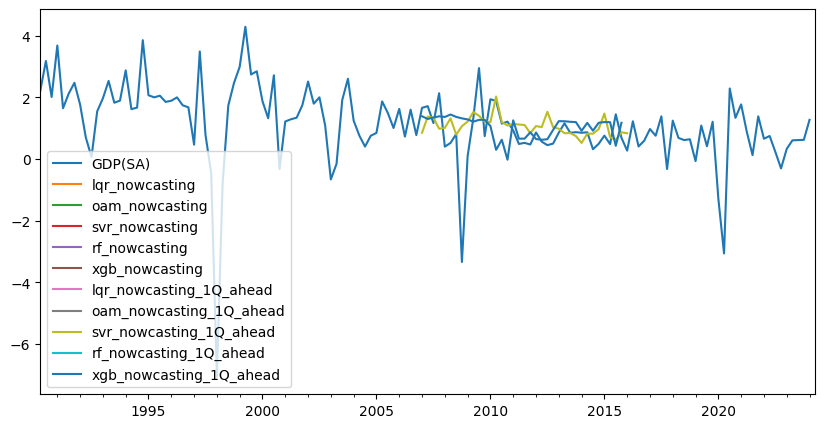

In [ ]:
pd.concat([preprocess(data[['GDP(SA)']]), results]).plot(figsize=(10, 5))

In [ ]:
period_str = str(results.index[0])

In [ ]:
tempData = data.loc[:period_str]
for col in tempData:
    if lag == 0:
        continue
    lag = metaData.loc[col, 'Lag']
    tempData[col].iloc[-lag:] = pd.NA
realtimeData = tempData.copy()

In [ ]:
# lqr, oam
tempData = preprocess(ArimaExrapolation(realtimeData[coreVarialbes]))
trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
test_y = LQRPredict(trainX, trainY, testX)
results.loc[period_str, 'lqr_nowcasting'] = test_y[0]
test_y = OAMPredict(trainX, trainY, testX)
results.loc[period_str, 'oam_nowcasting'] = test_y[0]

In [ ]:
# svr
tempData = preprocess(knnExtraplation(realtimeData[coreVarialbes]))
trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
test_y = SVRPredict(trainX, trainY, testX)
results.loc[period_str, 'svr_nowcasting'] = test_y[0]


In [ ]:
# rf
selectedVariables = list(filter(lambda x: pd.notna(x), selectVarialbes(realtimeData, metaData)))
tempData = preprocess(knnExtraplation(realtimeData[selectedVariables]))
trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
test_y = randomForestPredict(trainX, trainY, testX)
results.loc[period_str, 'rf_nowcasting'] = test_y[0]

In [ ]:
# xgb
tempData = preprocess(ArimaExrapolation(realtimeData[sentimentBasedVarialbes]))
trainX, trainY, testX = splitAndRollingData(tempData, seqLength=1)
test_y = XGBoostPredict(trainX, trainY, testX)
results.loc[period_str, 'xgb_nowcasting'] = test_y[0]

In [ ]:
results

,lqr_nowcasting,oam_nowcasting,svr_nowcasting,rf_nowcasting,xgb_nowcasting,lqr_nowcasting_1Q_ahead,oam_nowcasting_1Q_ahead,svr_nowcasting_1Q_ahead,rf_nowcasting_1Q_ahead,xgb_nowcasting_1Q_ahead
2007Q4,-0.146041,0.461738,0.837761,1.181119,1.386425,NaN,NaN,NaN,NaN,NaN
2008Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Forcast

In [ ]:
forcasts = pd.DataFrame(index=['0Q Ahead', '1Q Ahead'], columns=['lqr_nowcasting', 'oam_nowcasting', 'svr_nowcasting', 'rf_nowcasting', 'xgb_nowcasting'])

## SA

In [ ]:
data = x13SA(data)

In [ ]:
data.to_excel(f'data(SA){datetime.today().strftime("%Y%m%d")}.xlsx')

In [ ]:
data = pd.read_excel(f'data(SA){datetime.today().strftime("%Y%m%d")}.xlsx', index_col=0)
# data = pd.read_excel(f'data(SA){20240315}.xlsx', index_col=0)

In [ ]:
data.index = pd.PeriodIndex(data.index, freq='M')

## Manipulate

In [ ]:
# data = data.reindex(pd.period_range(start='1990-01', end='2024-6', freq='M'))

In [ ]:
# data = extend(data, '202312', '수출액', 2.1, 'yoy')
# data = extend(data, '202312', '수입액', -11.1, 'yoy')

In [ ]:
# data.loc['202307', '소매판매액지수(SA)'] = np.nan
# data.loc['202307', '설비투자지수(SA)'] = np.nan
# data.loc['202307', '제조업생산지수(SA)'] = np.nan
# data.loc['202307', '전산업생산지수서비스업(SA)'] = np.nan
# data.loc['202308', 'WTI유가현물'] = np.nan

In [ ]:
# data.loc['202307', '소비자물가지수'] = np.nan
# data.loc['202307', '소비자물가지수(농산물석유류제외)'] = np.nan
# data.loc['202307', '소비자물가지수(식료품에너지제외)'] = np.nan

## 1Q Ahead

In [ ]:
data = data.reindex(pd.period_range(start='1990-01', end='2024-9', freq='M'))

### Core + ARIMA + (LQR + OptimARIMA)

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +coreVarialbes]

# extraplation
tempData = ArimaExrapolation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength, ahead=1)
print(trainX.shape, trainY.shape, testX.shape)

# predict
test_y = LQRPredict(trainX, trainY, testX)
forcasts.loc['1Q Ahead', 'lqr_nowcasting'] = test_y[0]

test_y = OAMPredict(trainX, trainY, testX)
forcasts.loc['1Q Ahead', 'oam_nowcasting'] = test_y[0]

(96, 1, 9) (96,) (1, 1, 9)


  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0, 0)


### Correlation Based Variable Selection + KNN + RF

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
selectedVariables = selectVarialbes(preprocess(tempData), metaData)
tempData = tempData[selectedVariables]

# extraplation
tempData = knnExtraplation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength, ahead=1)
print(trainX.shape, trainY.shape, testX.shape)

# predict
#test_y = SVRPredict(trainX, trainY, testX)
test_y = randomForestPredict(trainX, trainY, testX)
#test_y = XGBoostPredict(trainX, trainY, testX)

(58, 1, 17) (58,) (1, 1, 17)


In [ ]:
forcasts.loc['1Q Ahead', 'rf_nowcasting'] = test_y[0]

In [ ]:
selectedVariables

['GDP(SA)',
 '협의통화(평잔,SA)',
 'KOSPI(평균)',
 '수입물가지수',
 '수입물량지수',
 '원파운드환율(평균)',
 '제조업내수판매실적BSI',
 '경제심리지수(순환변동치)',
 '경기동행종합지수',
 '제조업제품출하지수(SA)',
 '소매판매액지수(SA)',
 '건설기성액(SA)',
 '임시근로자수(SA)',
 '소비자심리지수',
 '통합재정수지',
 '제조업전력사용량',
 '세계무역량지수(SA)',
 'Dubai유가현물']

### Sentiment Based Varialbe Selection + ARIMA + XGB

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +sentimentBasedVarialbes]

# extraplation
tempData = ArimaExrapolation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength, ahead=1)
print(trainX.shape, trainY.shape, testX.shape)

# predict
#test_y = SVRPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'svr_nowcasting'] = test_y[0]

#test_y = randomForestPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'rf_nowcasting'] = test_y[0]

test_y = XGBoostPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'xgb_nowcasting'] = test_y[0]

(62, 1, 13) (62,) (1, 1, 13)


In [ ]:
forcasts.loc['1Q Ahead', 'xgb_nowcasting'] = test_y[0]

### Core Varialbe Selection + KNN + SVR

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +coreVarialbes]

# extraplation
tempData = knnExtraplation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength, ahead=1)
print(trainX.shape, trainY.shape, testX.shape)

# predict
test_y = SVRPredict(trainX, trainY, testX)
#test_y = randomForestPredict(trainX, trainY, testX)
#test_y = XGBoostPredict(trainX, trainY, testX)

(96, 1, 9) (96,) (1, 1, 9)


In [ ]:
forcasts.loc['1Q Ahead', 'svr_nowcasting'] = test_y[0]

## 0Q Ahead

In [ ]:
data = data.reindex(pd.period_range(start='1990-01', end='2024-6', freq='M'))

### Core + ARIMA + (LQR + OptimARIMA)

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +coreVarialbes]

# extraplation
tempData = ArimaExrapolation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength)
print(trainX.shape, trainY.shape, testX.shape)

# predict
test_y = LQRPredict(trainX, trainY, testX)
forcasts.loc['0Q Ahead', 'lqr_nowcasting'] = test_y[0]

test_y = OAMPredict(trainX, trainY, testX)
forcasts.loc['0Q Ahead', 'oam_nowcasting'] = test_y[0]

(96, 1, 9) (96,) (1, 1, 9)


  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0, 0)


In [ ]:
forcasts

,lqr_nowcasting,oam_nowcasting,svr_nowcasting,rf_nowcasting,xgb_nowcasting
0Q Ahead,-0.395558,0.309678,NaN,NaN,NaN
1Q Ahead,-0.056849,0.422019,0.819967,0.658617,0.785686


### Correlation Based Variable Selection + KNN + RF

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
selectedVariables = selectVarialbes(preprocess(tempData), metaData)
tempData = tempData[selectedVariables]

# extraplation
tempData = knnExtraplation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength)
print(trainX.shape, trainY.shape, testX.shape)

# predict
#test_y = SVRPredict(trainX, trainY, testX)
test_y = randomForestPredict(trainX, trainY, testX)
#test_y = XGBoostPredict(trainX, trainY, testX)

(58, 1, 17) (58,) (1, 1, 17)


In [ ]:
forcasts.loc['0Q Ahead', 'rf_nowcasting'] = test_y[0]

In [ ]:
selectedVariables

['GDP(SA)',
 '협의통화(평잔,SA)',
 'KOSPI(평균)',
 '수입물가지수',
 '수입물량지수',
 '원파운드환율(평균)',
 '제조업내수판매실적BSI',
 '경제심리지수(순환변동치)',
 '경기동행종합지수',
 '제조업제품출하지수(SA)',
 '소매판매액지수(SA)',
 '건설기성액(SA)',
 '임시근로자수(SA)',
 '소비자심리지수',
 '통합재정수지',
 '제조업전력사용량',
 '세계무역량지수(SA)',
 'Dubai유가현물']

### Sentiment Based Varialbe Selection + ARIMA + XGB

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +sentimentBasedVarialbes]

# extraplation
tempData = ArimaExrapolation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength)
print(trainX.shape, trainY.shape, testX.shape)

# predict
#test_y = SVRPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'svr_nowcasting'] = test_y[0]

#test_y = randomForestPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'rf_nowcasting'] = test_y[0]

test_y = XGBoostPredict(trainX, trainY, testX)
#forcasts.loc[testDate, 'xgb_nowcasting'] = test_y[0]

(62, 1, 13) (62,) (1, 1, 13)


In [ ]:
forcasts.loc['0Q Ahead', 'xgb_nowcasting'] = test_y[0]

### Core Varialbe Selection + KNN + SVR

In [ ]:
seqLength = 1

In [ ]:
tempData = copy.deepcopy(data)

# select variables
tempData = tempData[['GDP(SA)'] +coreVarialbes]

# extraplation
tempData = knnExtraplation(tempData)

# preprocess
tempData = preprocess(tempData)

# drop na
tempData = dropStartingNa(tempData)

# split dataset
trainX, trainY, testX = splitAndRollingData(tempData, seqLength)
print(trainX.shape, trainY.shape, testX.shape)

# predict
test_y = SVRPredict(trainX, trainY, testX)
#test_y = randomForestPredict(trainX, trainY, testX)
#test_y = XGBoostPredict(trainX, trainY, testX)

(96, 1, 9) (96,) (1, 1, 9)


In [ ]:
forcasts.loc['0Q Ahead', 'svr_nowcasting'] = test_y[0]

## Result

In [ ]:
forcasts

,lqr_nowcasting,oam_nowcasting,svr_nowcasting,rf_nowcasting,xgb_nowcasting
0Q Ahead,-0.395558,0.309678,0.94721,0.634819,0.785686
1Q Ahead,-0.056849,0.422019,0.819967,0.658617,0.785686


In [ ]:
forcasts.to_excel(f'result{datetime.today().strftime("%Y%m%d")}.xlsx')